In [1]:
%cd ../..

/home/maximilian/Github/melp


In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/00


In [3]:
from melp import Detector
mu3e_detector = Detector.initFromROOT("run42_20000.root")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  True
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [4]:
file = ROOT.TFile("run42_20000_sorted_test.root")
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")

In [5]:
ttree_mu3e.GetEntry(1199)

21431

In [6]:
# 1199 : 36, 39

In [7]:

list_traj = list(ttree_mu3e.traj_ID)

list_traj_vx = list(ttree_mu3e.traj_vx)
list_traj_vy = list(ttree_mu3e.traj_vy)
list_traj_vz = list(ttree_mu3e.traj_vz)

list_traj_px = list(ttree_mu3e.traj_px)
list_traj_py = list(ttree_mu3e.traj_py)
list_traj_pz = list(ttree_mu3e.traj_pz)

list_traj_pid = list(ttree_mu3e.traj_type)
list_traj_particle_type = []
for i in range(len(list_traj)):
    list_traj_particle_type.append(int(repr(list_traj_pid[i])[-1]))

In [8]:
#ttree_mu3e.GetEntry(1102)
list_tilehit_tile = list(ttree_mu3e.tilehit_tile)
list_tilehit_mci = list(ttree_mu3e.tilehit_mc_i)
list_tilehit_tid = []

for index in list_tilehit_mci:
    ttree_mu3e_mc.GetEntry(index)
    list_tilehit_tid.append(ttree_mu3e_mc.tid)

In [9]:
list_traj, list_tilehit_tid

([892758,
  892769,
  892778,
  892782,
  892786,
  892793,
  892797,
  892801,
  892820,
  892824,
  892828,
  892832,
  892833,
  892842,
  892846,
  892847,
  892851,
  892855,
  892173,
  892183,
  892184,
  892205,
  892237,
  891563,
  892885,
  892883,
  892914,
  887501,
  886875,
  886874,
  892987,
  892986,
  885522,
  885528,
  893067,
  893089,
  884960,
  884174,
  893144,
  883794,
  881147,
  893227,
  893236,
  893222,
  875735,
  893306,
  893303,
  870730,
  869638,
  866457,
  865752,
  893399,
  893419,
  893418,
  862868,
  893451,
  893468,
  861858,
  893499,
  893501,
  859525,
  859524,
  893569,
  839882,
  807397,
  893611],
 [865752,
  893177,
  884960,
  892990,
  865752,
  883794,
  884960,
  885528,
  885522,
  887501,
  893201,
  839882,
  875735,
  859525,
  893177,
  887501,
  892928,
  883794,
  883794,
  883794])

In [10]:
#tid_tilehit_tile = {}

#for current_frame in range(ttree_mu3e.GetEntries()):
#    ttree_mu3e.GetEntry(current_frame)
#    
#    list_tilehit_tile = list(ttree_mu3e.tilehit_tile)
#    list_tilehit_mci = list(ttree_mu3e.tilehit_mc_i)
#    list_tilehit_tid = []
#    
#    for index in list_tilehit_mci:
#        ttree_mu3e_mc.GetEntry(index)
#        list_tilehit_tid.append(ttree_mu3e_mc.tid)
#    
#    for index in range(len(list_tilehit_tile)):
#        if tid_tilehit_tile.get(list_tilehit_tid[index]):
#            tid_tilehit_tile[list_tilehit_tid[index]].append(list_tilehit_tile[index])
#        else:
#            tid_tilehit_tile[list_tilehit_tid[index]] = [list_tilehit_tile[index]]

In [11]:
#len(tid_tilehit_tile)

In [12]:
index_current = 39

In [13]:
def get_radius(px: float, py: float, particle_type: int, B: float): 
    
    p_t = np.sqrt((px)**2 + (py)**2)
    
    if particle_type == 0:  # photon
        return np.NINF
    elif particle_type == 1:  # positron
        q = +1
    elif particle_type == 2:  # electron
        q = -1
    else:
        return np.NaN
    
    r = p_t / (0.3*B*q)
    
    return r

In [14]:
def get_circ(hx: float, hy: float, r: float, l: float):
    theta_max = l * np.pi
    theta = np.linspace(0, theta_max, 100)
    x =  r*np.cos(theta) + hx
    y =  r*np.sin(theta) + hy
    
    return x, y

In [15]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def get_theta(px, py, pz):
    v1 = np.array([px,py,pz])
    v2 = np.array([0,0,1])
    
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) / np.pi) * 180 - 90

In [16]:
def get_helix(hx: float, hy: float, hz: float, r: float, theta_i: float, phi_offset: float, l: float):
    theta_max = l * np.pi
    theta = np.linspace(0, theta_max, 100)
    
    x = r*np.cos(theta+phi_offset) + hx
    y = r*np.sin(theta+phi_offset) + hy
    z = 2 * np.pi * r * np.tan(np.pi*theta_i/180) * theta / (2*np.pi)
    
    return x, y, z

In [17]:
# generate radius for all trajectories
list_traj_r = []
for i in range(len(list_traj)):
    list_traj_r.append(get_radius(list_traj_px[i],list_traj_py[i],list_traj_particle_type[i], -1.))

In [18]:
# generate theta for all traj
list_traj_theta = []
for i in range(len(list_traj)):
    px = list_traj_px[i]
    py = list_traj_py[i]
    pz = list_traj_pz[i]
    list_traj_theta.append(get_theta(px,py,pz))

In [19]:
#list_traj_theta

In [20]:
# helix middle point

v = np.cross([list_traj_px[index_current], list_traj_py[index_current], 0], [0,0,1])

v_n = v / np.sqrt(np.sum(v**2))
r = list_traj_r[index_current]

hx = list_traj_vx[index_current] + r*v_n[0]
hy = list_traj_vy[index_current] + r*v_n[1]
hz = list_traj_vz[index_current]

theta = list_traj_theta[index_current]

In [21]:
# tilehit position for given traj
x_t = []
y_t = []
z_t = []
for index in range(len(list_tilehit_tid)):
    if list_tilehit_tid[index] == list_traj[index_current]:
        x_t.append(mu3e_detector.TileDetector.tile[list_tilehit_tile[index]].pos[0])
        y_t.append(mu3e_detector.TileDetector.tile[list_tilehit_tile[index]].pos[1])
        z_t.append(mu3e_detector.TileDetector.tile[list_tilehit_tile[index]].pos[2])

In [23]:
x,y,z = get_helix(hx, hy, hz, r, theta, 2)

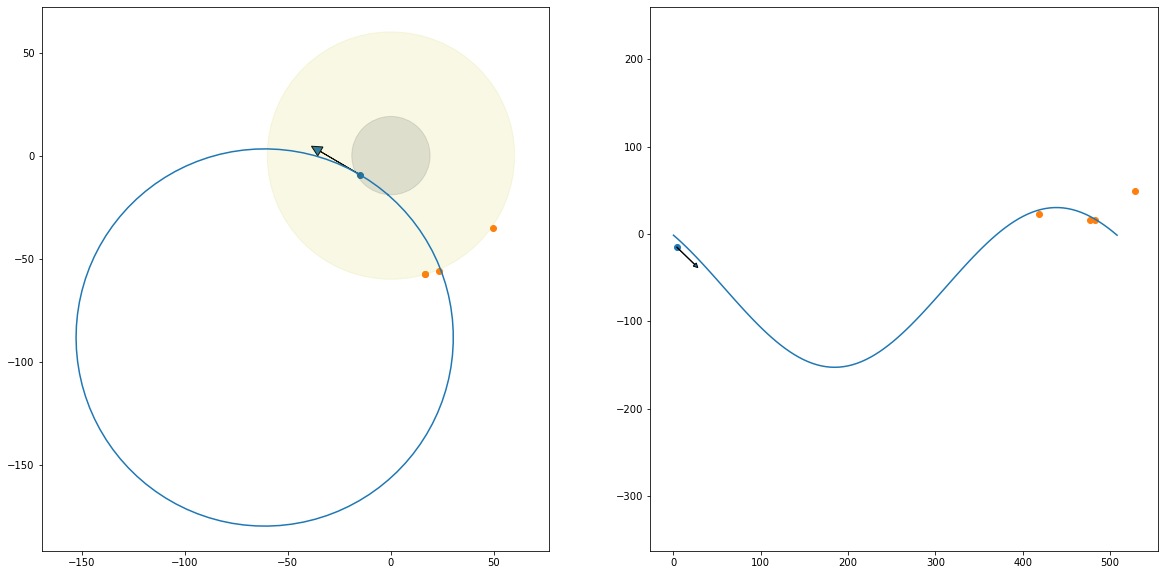

In [29]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

ax = ax_arr[0]
ax.scatter(list_traj_vx[index_current], list_traj_vy[index_current])
ax.scatter(np.array(x_t), np.array(y_t))
ax.arrow(list_traj_vx[index_current], list_traj_vy[index_current], list_traj_px[index_current], list_traj_py[index_current],length_includes_head=True, head_width=5, head_length=5)
ax.plot(x,y)

circle1 = plt.Circle((0, 0), 60, color='y', alpha = 0.1)
circle2 = plt.Circle((0, 0), 19, color='black', alpha = 0.1)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.axis('equal')

ax = ax_arr[1]
ax.scatter(list_traj_vz[index_current], list_traj_vx[index_current])
ax.scatter(np.array(z_t), np.array(x_t))
ax.arrow(list_traj_vz[index_current], list_traj_vx[index_current], list_traj_pz[index_current], list_traj_px[index_current],length_includes_head=True, head_width=5, head_length=5)
ax.plot(z,x)

ax.axis('equal')

plt.show()

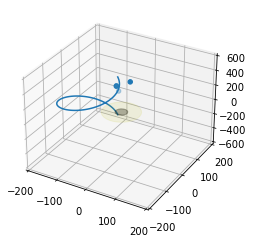

In [25]:
#%matplotlib notebook
import matplotlib
#matplotlib.use('WebAgg') 

from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

circle1 = plt.Circle((0, 0), 60, color='y', alpha = 0.1)
circle2 = plt.Circle((0, 0), 19, color='black', alpha = 0.3)
ax.add_patch(circle2)
art3d.pathpatch_2d_to_3d(circle2, z=0, zdir="z")
ax.add_patch(circle1)
art3d.pathpatch_2d_to_3d(circle1, z=0, zdir="z")


ax.plot(x,y,z)
ax.scatter(np.array(x_t), np.array(y_t), np.array(z_t))

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(-600, 600)

plt.show()